In [ ]:
# import modules
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

import random
from torch.utils.data import DataLoader, TensorDataset
from pandas import DataFrame
from torch import Tensor

In [16]:
import pandas as pd

data = pd.read_csv('Data/TrainingData-Salah.csv')

# Split the data into a training and testing set
rows = data.shape[0]
columns = data.shape[1]
print(rows, columns)

datarows = data[["Points", "Goals", "Assists", "CleanSheets", "Saves", "BonusPoints", 'PointsInLastFive',
       'MinutesInLastFive', 'GoalsInLastFive', 'xGoalsInLastFive',
       'xAssistsInLastFive', 'CleanSheetsInLastFive',
       'GoalsConcededInLastFive', 'xGoalsConcededInLastFive',
       'SavesInLastFive', 'BonusPointsInLastFive',
       'BonusPointsRatingInLastFive','OpponentGoalsScoredInLastFive',
       'OpponentGoalsConcededInLastFive']]

columns = datarows.shape[1]
actual_values = data['ActualPoints'].values

X = np.array(datarows)
y = np.array(actual_values)

15 35


In [3]:

from sklearn.datasets import fetch_california_housing
 
data = fetch_california_housing()
print(data.feature_names)
 
X, y = data.data, data.target

['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']


In [5]:
print(type(X))

<class 'numpy.ndarray'>


In [39]:

import torch.nn as nn
import torch.optim as optim
# Define the model
model = nn.Sequential(
    nn.Linear(columns, 100),
    nn.ReLU(),
    nn.Linear(100, 50),
    nn.ReLU(),
    nn.Linear(50, 24),
    nn.ReLU(),
    nn.Linear(24, 1)
)

# loss function and optimizer
loss_fn = nn.MSELoss()  # mean square error
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [43]:

import copy
import numpy as np
import torch
import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# train-test split of the dataset
X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y, train_size=0.7, shuffle=True)

# Standardizing data
scaler = StandardScaler()
scaler.fit(X_train_raw)
X_train = scaler.transform(X_train_raw)
X_test = scaler.transform(X_test_raw)

X_train = torch.tensor(X_train_raw, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).reshape(-1, 1)
X_test = torch.tensor(X_test_raw, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32).reshape(-1, 1)

# training parameters
n_epochs = 10000   # number of epochs to run
batch_size = 10  # size of each batch
batch_start = torch.arange(0, len(X_train), batch_size)
 
# Hold the best model
best_mse = np.inf   # init to infinity
best_weights = None
history = []
 
# training loop
for epoch in range(n_epochs):
    model.train()
    with tqdm.tqdm(batch_start, unit="batch", mininterval=0, disable=True) as bar:
        bar.set_description(f"Epoch {epoch}")
        for start in bar:
            # take a batch
            X_batch = X_train[start:start+batch_size]
            y_batch = y_train[start:start+batch_size]
            # forward pass
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            # update weights
            optimizer.step()
            # print progress
            bar.set_postfix(mse=float(loss))
    # evaluate accuracy at end of each epoch
    model.eval()
    y_pred = model(X_test)
    mse = loss_fn(y_pred, y_test)
    mse = float(mse)
    history.append(mse)
    if mse < best_mse:
        best_mse = mse
        best_weights = copy.deepcopy(model.state_dict())
 
# restore model and return best accuracy
model.load_state_dict(best_weights)


Epoch 6038:   0%|          | 0/1 [00:00<?, ?batch/s]


KeyboardInterrupt: 

MSE: 17.00
RMSE: 4.12


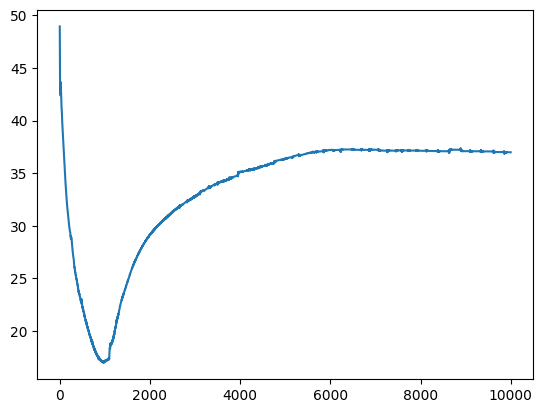

In [41]:
import matplotlib.pyplot as plt

print("MSE: %.2f" % best_mse)
print("RMSE: %.2f" % np.sqrt(best_mse))
plt.plot(history)
plt.show()

In [42]:
model.eval()
with torch.no_grad():
    # Test out inference with 5 samples
    for i in range(5):
        X_sample = X_test_raw[i: i+1] # to make 2d array
        X_sample = scaler.transform(X_sample)
        X_sample = torch.tensor(X_sample, dtype=torch.float32)
        y_pred = model(X_sample)
        print(f"{X_test_raw[i]} -> {y_pred[0].numpy()} (expected {y_test[i].numpy()})")

[106.    10.     5.     4.     0.    14.    47.   450.     1.     3.5
   0.69   3.     2.     4.31   0.     6.   131.     0.     0.  ] -> [0.44516623] (expected [5.])
[ 44.     3.     4.     1.     0.     5.    34.   433.     3.     2.28
   2.32   1.     4.     5.84   0.     5.   119.     0.     0.  ] -> [0.34679627] (expected [1.])
[ 75.     7.     4.     2.     0.    11.    52.   433.     2.     4.14
   2.25   1.     5.     5.61   0.    11.   157.     0.     0.  ] -> [0.38769895] (expected [16.])
[127.    11.     7.     5.     0.    17.    42.   426.     3.     2.4
   0.94   2.     5.     6.13   0.     6.   120.     0.     0.  ] -> [0.2918623] (expected [13.])
[ 59.     5.     4.     1.     0.     8.    44.   433.     2.     3.55
   2.27   1.     5.     6.14   0.     8.   143.     0.     0.  ] -> [0.37022173] (expected [15.])
